# Analysis

In [5]:
import os
import pandas as pd   # module to work with data in DataFrames.
import seaborn as sns  # module to plot DataFrames in an easy way
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# seaborn comes with default presets (called 'contents') for figure's aesthetics, 
# such as the font size, figure size etc. 
sns.set_context('talk') # try: 'talk', 'poster', 'notebook'

In [21]:
# Get current result files.
single_result_dir = Path('../single_assessment/results').absolute()
single_result_file_names = os.listdir(single_result_dir)
single_result_file_names = list(filter(lambda name: str.startswith(name, 'result'), single_result_file_names))

single_result_files_paths = []
for name in single_result_file_names:
    single_result_files_paths.append(single_result_dir / name)

single_result_files_paths

[PosixPath('/home/max/git/PerceptionAndImageQuality/analysis/../single_assessment/results/result_20220116-205338_max.csv'),
 PosixPath('/home/max/git/PerceptionAndImageQuality/analysis/../single_assessment/results/result_20220116-210153_marius.csv')]

In [22]:
# we read the data
file = single_result_files_paths.pop()
df = pd.read_csv(file)
observer_num = 0
df['observer'] = observer_num
observer_num += 1

for path in single_result_files_paths:
    df_tmp = pd.read_csv(path)
    df_tmp['observer'] = observer_num
    df = pd.concat((df, df_tmp))

#for file in single_result_files_paths:

# if we have more observers we could read their files, assign the column observer 
# with their name, and concatenate the DataFrames with pd.concat(). Example:
#df1 = pd.read_csv('Person1.csv')
#df1['observer'] = 'Person1'      # creates a new column called 'observer'
#df2 = pd.read_csv('Person2.csv') # reads second file
#df2['observer'] = 'Person2'     
#df = pd.concat((df, df2))        # concatenates both dataframes in one
df


,test_image,response,resptime,observer
0,H6_1.0_chroma.JPG,4,6.411650,0
1,H27_1.0_chroma.JPG,3,3.590774,0
2,I21_1.0_chroma.JPG,5,2.798328,0
3,H14_1.0_chroma.JPG,2,2.703999,0
4,H25_1.0_chroma.JPG,4,3.903137,0
...,...,...,...,...
40,H28_1.0_chroma.JPG,3,3.825971,1
41,H23_1.0_chroma.JPG,6,16.109562,1
42,I13_1.0_chroma.JPG,6,5.256825,1
43,H19_1.0_chroma.JPG,4,7.310796,1


In [23]:
# explore the first entries in your data
#df

# Sanity checks
We expect 30 historic and 15 modern images used during tests.
Only responses from [0, 9] accepted.

In [40]:
# sanity checks: how many groups do you expect per categorical variable?
assert len(df['test_image'].unique()) == 30 + 15
assert max(df['response'].unique()) <= 9
assert min(df['response'].unique()) >= 0

## Visualizing data for one image


In [47]:
# selecting data for only one picture

image_names = df['test_image'].unique()
current_image = image_names[0]
d = df[df['test_image'] == current_image]



In [46]:
d

,test_image,response,resptime,observer
0,H6_1.0_chroma.JPG,4,6.411650,0
6,H6_1.0_chroma.JPG,2,1.375361,1


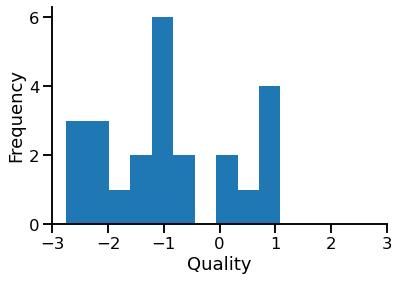

In [15]:
# distribution of quality values for this image category
plt.hist(d['quality_value'])
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.xlim((-3, 3))
sns.despine()

In [48]:
### barplot aggregated by k
## we call the function catplot() (cat: categorical)
g = sns.catplot(x='k', y='quality_value', data=d,
                kind='bar', ci='sd', color='#e34a33')


g.set_ylabels('Quality')
g.set_xlabels('Kontrast')
g.set(ylim = (-3, 3))
#plt.title(picname)

ValueError: Could not interpret input 'k'

Text(0.5, 1.0, 'H6_1.0_chroma.JPG')

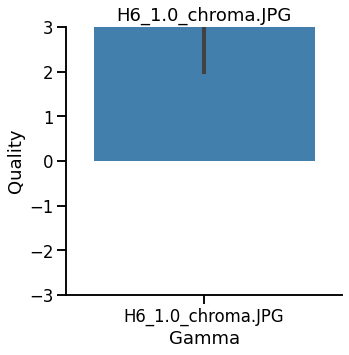

In [53]:
### barplot aggregated by g
g = sns.catplot(x='test_image', y='response', data=d, kind='bar', color='#3182bd',
            ci='sd')
g.set_ylabels('Quality')
g.set_xlabels('Gamma')
g.set(ylim = (-3, 3))
plt.title(current_image)

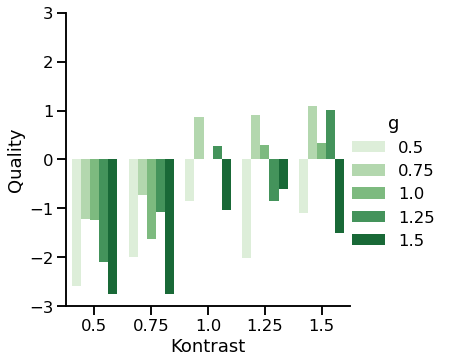

In [18]:
#### barplot aggregated by k and g
g = sns.catplot(x='k', y='quality_value', data=d, hue='g', palette='Greens',
                kind='bar', ci='sd')
g.set_ylabels('Quality')
g.set_xlabels('Kontrast')
g.set(ylim = (-3, 3))

## Visualizing data from all pictures

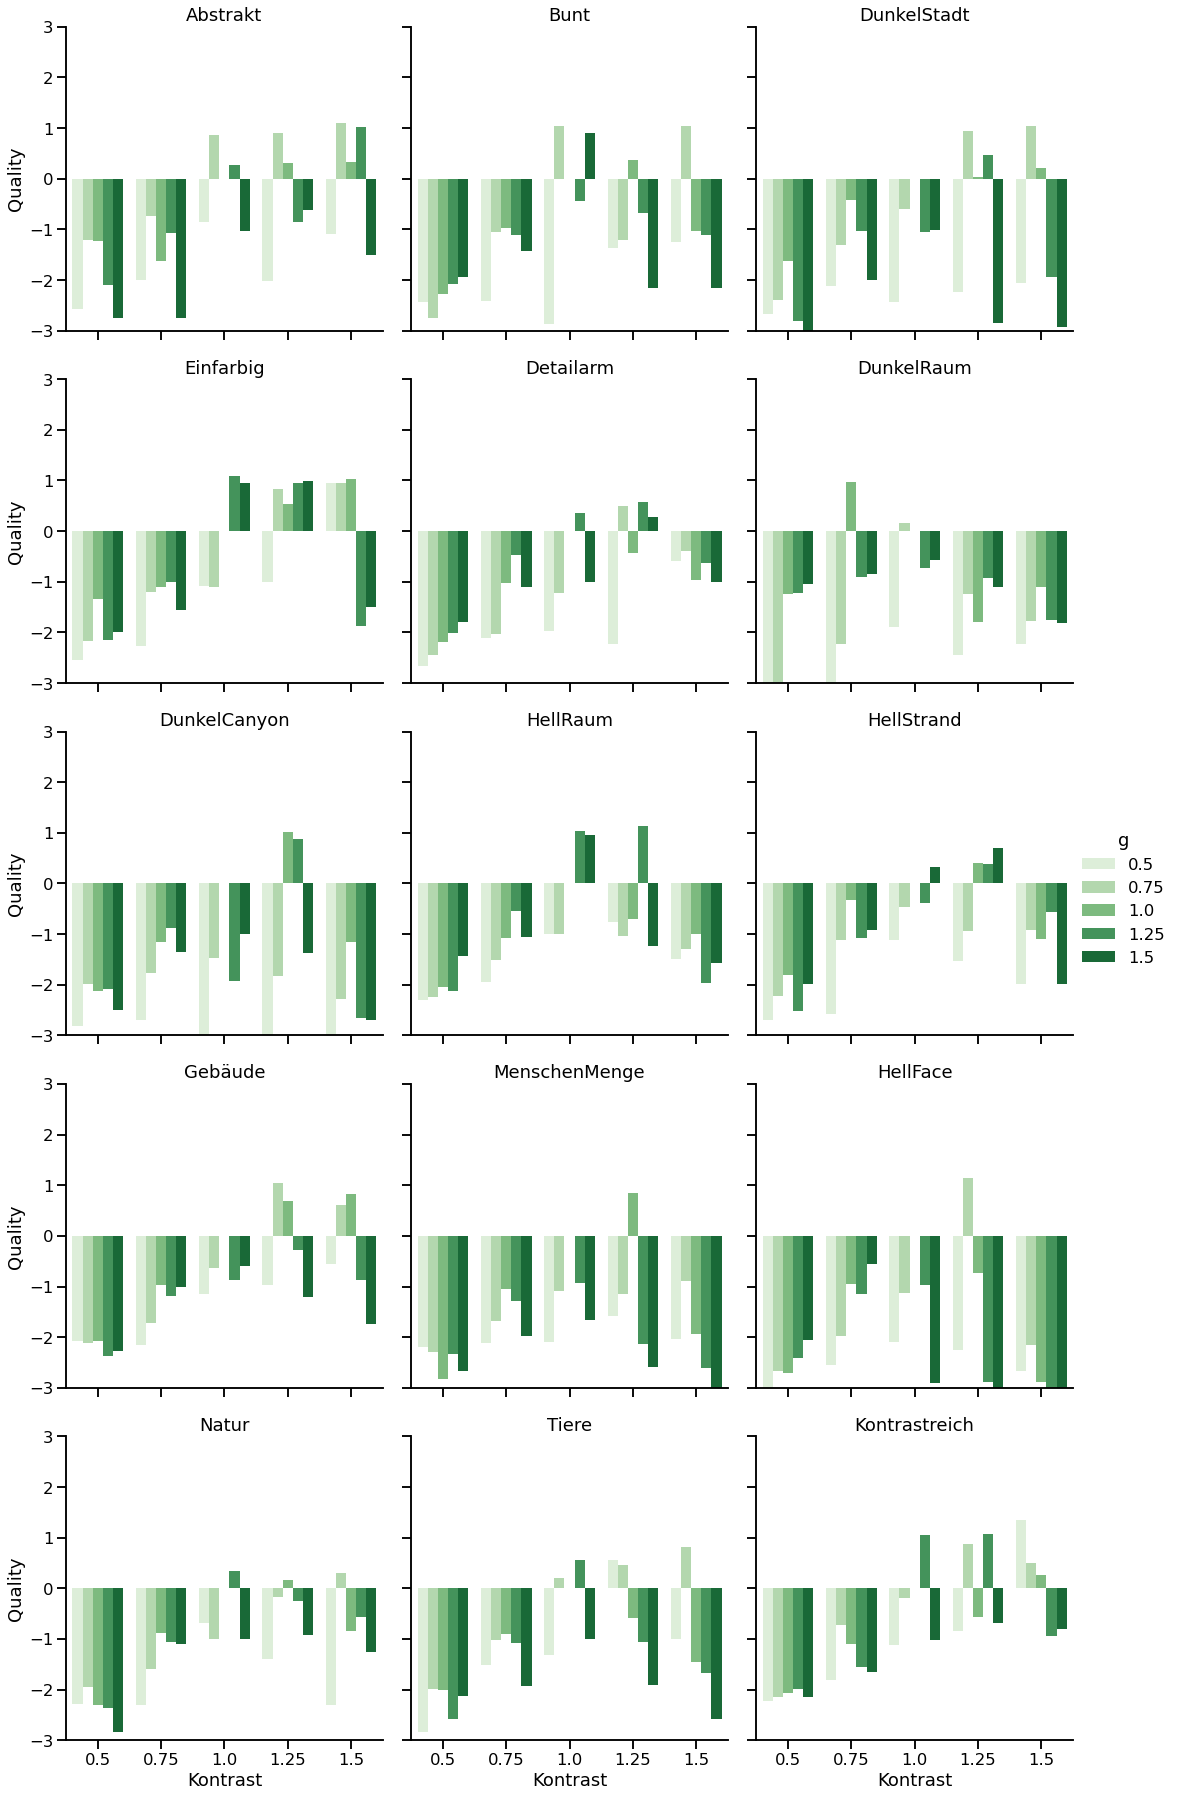

In [19]:
# %%  Using small multiples to visualize data from all pictures in one figure 
g = sns.catplot(x='k', y='quality_value', data=df, hue='g',
                col='picture', 
                col_wrap = 3, 
                kind='bar', ci='sd', 
                #height=4,
                palette='Greens')



g.set_ylabels('Quality')
g.set_xlabels('Kontrast')
g.set_titles('{col_name}')
g.set(ylim = (-3, 3))
g.savefig('allpictures_in_different_panels.pdf')


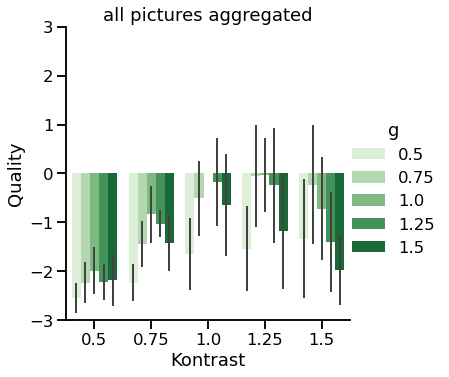

In [20]:
# %% collapsing all pictures into one visualization
g = sns.catplot(x='k', y='quality_value', data=df, hue='g',
                kind='bar', ci='sd', errwidth=2,
                palette='Greens')
g.set_ylabels('Quality')
g.set_xlabels('Kontrast')
g.set(ylim = (-3, 3))

plt.title('all pictures aggregated')
g.savefig('allpictures_aggregated.pdf')


## Some statistical analysis

In [21]:
# we load scipy
import scipy

### t-test 
With a t-test we can test whether the values of two groups have the same mean. The null-hypothesis states that the mean difference between the two samples is zero. 
The test gives us a 'p-value', the conditional probability for the observed difference between means under the assumption (condition) that the null-hypothesis is true. When the p-value is smaller than a criterion value (0.05 for 95 % confidence by convention), we say we *reject* the null-hypothesis. In other words, a p value <.05 indicates that the difference between the two samples is unlikely to be truly zero.

In [22]:
# we select the data we want to compare. We select the data for k=0.5 and k=1.5 
# and assign them to two vectors, k1 and k2
k1 = df[df['k']==0.5]
k2 = df[df['k']==1.0]

#k1['quality_value']
#k2['quality_value']


In [23]:
# we call a t-test for two independent samples 
tstat, pvalue = scipy.stats.ttest_ind(k1['quality_value'], 
                                      k2['quality_value']) 

print('p-value:', pvalue)

p-value: 2.606247110907521e-21


The p-value is << 0.05, so we reject the null hypothesis and say that the difference is significant.

### ANOVA
If we want to compare the means of more than 2 groups, we need to perform an Analysis of Variance (ANOVA). The null-hypothesis in the ANOVA states that there is no difference between the means of the groups. A p-value less than 0.05 (at 95 %) rejects this general hypothesis without indicating which groups are different from one another.

In [24]:
# for an ANOVA we need the python module statsmodels (statistical models)
import statsmodels.api as sm  

# the particular function we need is called ols()
# (ols: ordinary least squares, that is the type of fitting)
from statsmodels.formula.api import ols   

In [25]:
# we need to set up a 'formula' for the model. This formula is similar to the syntax in R.

# on the left side of the tilde we put the dependent variable
# on the right side of the tilde we state the independent variables 
# the C( )  indicates that we consider the variable as a categorical variable (and not continuous)
# the sign + is not a sum, it is to indicate more than one variable.
# the sign * is not a multiplication, it is to indicate we want to also model interactions between the variables

# we call ols() passing the model 'formula'
mod = ols('quality_value ~ C(k) + C(g)', data=df)

# we fit the model
fit = mod.fit()

# we show the ANOVA table
sm.stats.anova_lm(fit)

,df,sum_sq,mean_sq,F,PR(>F)
C(k),4.0,121.098479,30.274620,40.554424,6.241619e-28
C(g),4.0,59.353084,14.838271,19.876634,9.159041e-15
Residual,351.0,262.027924,0.746518,NaN,NaN


The ANOVA table shows that for both variables k and g there is a signifficant effect (p-values < 0.05 for 95 % confidence). There is also a signifficant interaction term ('C(k):C(g)').


The p-values reject the null hypothesis, meaning that there is a significant difference between the means. But which ones? To answer that we need to perform a so-called post-hoc test. 

Post-hoc tests do all the pairwise comparisons (like a t-test), but correcting the p-value for multiple comparisons. This correction is needed because of statistical reasons. The risk of not correcting is that we will be detecting differences that are not there. (https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

In [26]:
# perform multiple pairwise comparison
from statsmodels.stats.multicomp import MultiComparison

# here we set-up the multiple comparison problem. 
# First argument: response variable, in this case the dependent variable: quality_value
# Second argument: groups. All groups to be compared
# Third argument (optional): significance level for test. Normally 0.05 for 95% confidence.

MultiComp = MultiComparison(df['quality_value'],
                             df['k'])
# here we compare the effect of 'k'. We also can change it and do 'g'.

# Call for multiple comparison: 
# the first argument is the test we will do, a t-test (same function as above)
# the second argument is the type of correction, in this case Bonferroni correction.
comp = MultiComp.allpairtest(scipy.stats.ttest_ind, method='bonf')
comp[0]

group1,group2,stat,pval,pval_corr,reject
0.5,0.75,-9.0713,0.0,0.0,True
0.5,1.0,-11.355,0.0,0.0,True
0.5,1.25,-11.0697,0.0,0.0,True
0.5,1.5,-7.3893,0.0,0.0,True
0.75,1.0,-4.4619,0.0,0.0002,True
0.75,1.25,-4.9838,0.0,0.0,True
0.75,1.5,-1.6373,0.1037,1.0,False
1.0,1.25,-0.6897,0.4916,1.0,False
1.0,1.5,1.9879,0.0489,0.4888,False
1.25,1.5,2.6678,0.0085,0.0849,False


The table shows all comparisons for k. The rightmost column says whether there is a significant difference between the groups tested (reject = True).

-------------------------------

----


## Extra example about Linear regression

Let's imagine we have a continuous x-variable, we measured a continous y-variable, in two experimental conditions. The file 'fictional_data.csv' provide such an example. We want to analyse if there is a linear relationship between x and y, and if there is a difference between conditions.

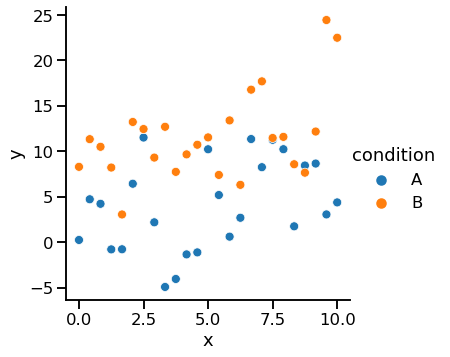

In [27]:
# we load a fictional dataset
df2 = pd.read_csv('fictional_data.csv')


# to make a scatter plot we use relplot() (rel: relationship)
g = sns.relplot(x='x', y='y', data=df2, hue='condition', kind='scatter')

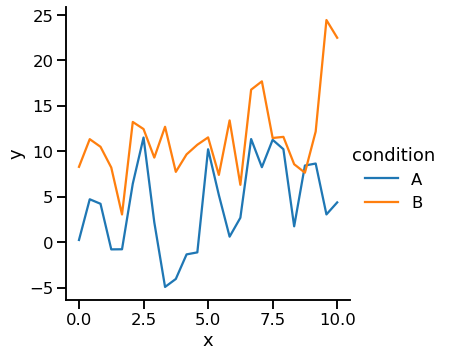

In [28]:
# or a line plot
g = sns.relplot(x='x', y='y', data=df2, hue='condition', kind='line')

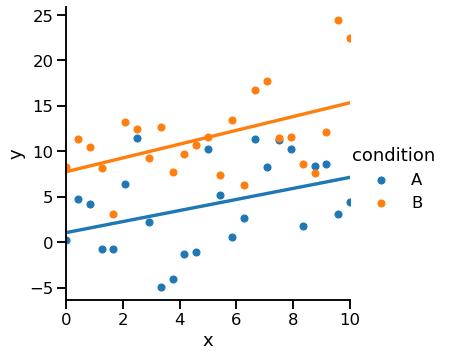

In [29]:
sns.lmplot(x='x', y='y', hue="condition", data=df2, 
           ci=None,
           scatter_kws={"s": 50, "alpha": 1})


### Statistical analysis: linear regression

In [33]:
# Model 1: all data included, not separated by condition
mod = ols('y ~ x', data=df2)

# we fit the model
fit = mod.fit()

# we show the summary of the statistical analysis
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     6.256
Date:                Thu, 13 Jan 2022   Prob (F-statistic):             0.0158
Time:                        17:15:32   Log-Likelihood:                -157.88
No. Observations:                  50   AIC:                             319.8
Df Residuals:                      48   BIC:                             323.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4193      1.594      2.772      0.008       1.214       7.625
x              0.6836      0.273      2.501      0.016       0.134       1.233
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   0.887
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.466
Skew:                          -0.016   Prob(JB):                        0.792
Kurtosis:                       2.528   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The table is full of details, what is important is the following.**
The model was $ y = slope \cdot x + intercept$, so we should get two estimated values... the slope and the intercept. 
These two values are the second table, the column 'coef', the slope is 0.6836 and intercept = 4.4193.

The same table also show us if these values are significantly different than zero (column "P>|t|"), which in case it is true for both the slope and the intercept (both p < 0.05).

So we can say that there is a significant linear relationship between the two variables.


Now we can do the same analysis but separated for each condition, A and B.

In [34]:
# Model 2: data separated by condition
mod1 = ols('y ~ x', data=df2[df2['condition']=='A'])
mod2 = ols('y ~ x', data=df2[df2['condition']=='B'])

# we fit the model
fit1 = mod1.fit()
fit2 = mod2.fit()

# we can use fit1.summary()..... 
# or instead of printing the big table, only get the parameters with...
fit1.params

Intercept    1.071696
x            0.608308
dtype: float64

In [35]:
fit2.params

Intercept    7.766852
x            0.758866
dtype: float64

Here we see that the slopes are not so different (0.6 and 0.76), but that the intercepts are very different (1.1 and 7.8). This observation also correspond with what we see in the visualization above.

We conclude that there is a linear relationship between variable x and y, and that it is different between conditions, specifically, there is a change in intercept.